In [1]:
from __future__ import print_function
import numpy as np
np.random.seed(1)
import sys
import sklearn
import sklearn.ensemble
%load_ext autoreload
%autoreload 2
from anchor import utils
from anchor import anchor_tabular
from numba import jit
import pickle
import matplotlib.pyplot as plt
from myUtils import *

### Loading the dataset
This dataset is about predicting if a person makes more or less than 50,000 dollars

In [2]:
# make sure you have adult/adult.data inside dataset_folder
dataset_folder = '.'
dataset = utils.load_dataset('adult', balance=True, dataset_folder=dataset_folder, discretize=True)

Let's train a classifier for this

In [3]:
c = sklearn.ensemble.RandomForestClassifier(n_estimators=50, n_jobs=5)
c.fit(dataset.train, dataset.labels_train)
print('Train', sklearn.metrics.accuracy_score(dataset.labels_train, c.predict(dataset.train)))
print('Test', sklearn.metrics.accuracy_score(dataset.labels_test, c.predict(dataset.test)))

Train 0.9350338780390594
Test 0.8489483747609943


### Getting an anchor

Now let's start the explainer. We need the training data to perturb instances.
`categorical_names` is a map from integer to list of strings, containing names for each
            value of the categorical features. Every feature that is not in
            this map will be considered as ordinal or continuous, and thus discretized.


In [4]:
explainer = anchor_tabular.AnchorTabularExplainer(
    dataset.class_names,
    dataset.feature_names,
    dataset.train,
    dataset.categorical_names)

In [5]:
my_utils = Utils(dataset, explainer, c)
exps_num = 1000
explanations = my_utils.compute_explanations(np.random.choice(len(dataset.test), exps_num))

0
50
100
150
200
250
300
350
400
450
500
550
600
650
700
750
800
850
900
950


In [6]:
pickle.dump( explanations, open( "exps.pickle", "wb" ))

In [7]:
explanations = pickle.load( open( "exps.pickle", "rb" ))

In [8]:
explanations.sort(key=lambda exp: exp.test_cov)

In [9]:
best = explanations[-10:]
best.reverse()

for exp in best:
    print("------------------------")
    exp_label =  c.predict(dataset.test[exp.index].reshape(1, -1))
    print('Prediction: ', explainer.class_names[exp_label[0]])
    print('Anchor: %s' % (' AND '.join(exp.names)))
    print('Precision: %.2f' % exp.precision)
    print('Coverage: %.2f' % exp.coverage)
    print('Anchor test precision: %.2f' % (np.mean(c.predict(dataset.test[exp.fit_examples]) == exp_label)))
    print('Anchor test coverage: %.2f' % (exp.test_cov))
    covered_labels = dataset.labels_test[exp.fit_examples]
    real_percentage = np.mean(covered_labels == exp_label)
    print('Anchor test REAL precision: %.2f' % real_percentage)

------------------------
Prediction:  b'<=50K'
Anchor: Marital Status = Never-married AND Age <= 28.00
Precision: 0.99
Coverage: 0.14
Anchor test precision: 0.95
Anchor test coverage: 0.15
Anchor test REAL precision: 0.95
------------------------
Prediction:  b'<=50K'
Anchor: Age <= 28.00 AND Marital Status = Never-married
Precision: 0.95
Coverage: 0.14
Anchor test precision: 0.95
Anchor test coverage: 0.15
Anchor test REAL precision: 0.95
------------------------
Prediction:  b'<=50K'
Anchor: Marital Status = Never-married AND Age <= 28.00 AND Capital Gain = 0
Precision: 0.98
Coverage: 0.15
Anchor test precision: 0.97
Anchor test coverage: 0.15
Anchor test REAL precision: 0.97
------------------------
Prediction:  b'<=50K'
Anchor: Age <= 28.00 AND Marital Status = Never-married AND Capital Gain = 0
Precision: 0.98
Coverage: 0.15
Anchor test precision: 0.97
Anchor test coverage: 0.15
Anchor test REAL precision: 0.97
------------------------
Prediction:  b'<=50K'
Anchor: Marital Status 

In [ ]:
exps = explenations[-len(explanations)//2:]
real_precisions = [np.mean(dataset.labels_test[exp.fit_examples] == c.predict(dataset.test[exp.index].reshape(1, -1)))
                   for exp in exps]
test_precisions = [np.mean(c.predict(dataset.test[exp.fit_examples]) == c.predict(dataset.test[exp.index].reshape(1, -1))) 
                   for exp in exps]

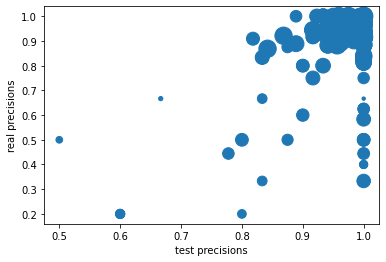

In [12]:
plt.scatter(test_precisions, real_precisions, s = range(len(exps)))
plt.xlabel('test precisions')
plt.ylabel('real precisions')
plt.show()